## Identification of Fraud from Enron Email
##### Sharad Mohan Vijalapuram

### Introduction 

Enron Corporation, an American energy company based in Houston, TX was formed by Kenneth Lay in 1985 and by the year 2000, it was one of the largest companies in the US. It is believed that Jeffrey Skilling was one of the key persons in developing a staff of executives that used accounting loopholes and poor financial reporting to hide billions of dollars in debt from failed deals and projects. Towards the end of 2001, the company collpsed into bankruptcy.

The Enron scandal, publicized in October 2001, eventually led to the bankruptcy of the company, whcih turned out to be the largest bankruptcy reorganization in American history at that time and the biggest audit failure.

The Enron dataset used in this project consists of financial and email data of a bunch of executives who worked for Enron. The goal of this project is to use different machine learning algorithms and potentially tune them to accurately identify if a person is of interest or not. As part of the project, I used different features of the data set and created a few new features when necessary to try and improve the accuracy, precision and recall of various different algorithms to finally pick one algorithm that has the best of the scores.  


In [45]:
# Load necessary packages and data
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline  
import sys
import pickle
import sklearn
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
from tester import test_classifier, dump_classifier_and_data
from sklearn.preprocessing import Imputer

with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

features_list = ['poi', 'salary', 'deferral_payments', 'total_payments', 'loan_advances',
                 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value',
                 'expenses', 'exercised_stock_options', 'long_term_incentive', 'other',
                 'restricted_stock', 'director_fees', 'to_messages', 'from_poi_to_this_person',
                 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)


### Data Auditing
For easier data access and manipulation, I change the data set to a pandas data frame and look at some basic information about the data set. I also replace any 'NaN' to numpy's nan to better identify and impute values if necessary later on.

The info method on the data frame reveals some basic information about the data set. The data set has 146 entries for 146 ENRON executives and 21 of their features as columns.

In [46]:
enrondf = pd.DataFrame.from_dict(data_dict, orient = 'index')
enrondf = enrondf.replace('NaN', np.nan)
enrondf[features_list]
enrondf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 21 columns):
salary                       95 non-null float64
to_messages                  86 non-null float64
deferral_payments            39 non-null float64
total_payments               125 non-null float64
exercised_stock_options      102 non-null float64
bonus                        82 non-null float64
restricted_stock             110 non-null float64
shared_receipt_with_poi      86 non-null float64
restricted_stock_deferred    18 non-null float64
total_stock_value            126 non-null float64
expenses                     95 non-null float64
loan_advances                4 non-null float64
from_messages                86 non-null float64
other                        93 non-null float64
from_this_person_to_poi      86 non-null float64
poi                          146 non-null bool
director_fees                17 non-null float64
deferred_income              49 non-null float

In [47]:
# Basic statistics about the data set
print 'Number of executives:', len(enrondf)
print 'Number of POIs:', len(enrondf.loc[enrondf.poi == True, 'poi'])
print 'Number of features:', enrondf.shape[1]

Number of executives: 146
Number of POIs: 18
Number of features: 21


In [48]:
enrondf.describe()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person
count,9.500000e+01,86.000000,3.900000e+01,1.250000e+02,1.020000e+02,8.200000e+01,1.100000e+02,86.000000,1.800000e+01,1.260000e+02,9.500000e+01,4.000000e+00,86.000000,9.300000e+01,86.000000,1.700000e+01,4.900000e+01,6.600000e+01,86.000000
mean,5.621943e+05,2073.860465,1.642674e+06,5.081526e+06,5.987054e+06,2.374235e+06,2.321741e+06,1176.465116,1.664106e+05,6.773957e+06,1.087289e+05,4.196250e+07,608.790698,9.190650e+05,41.232558,1.668049e+05,-1.140475e+06,1.470361e+06,64.895349
std,2.716369e+06,2582.700981,5.161930e+06,2.906172e+07,3.106201e+07,1.071333e+07,1.251828e+07,1178.317641,4.201494e+06,3.895777e+07,5.335348e+05,4.708321e+07,1841.033949,4.589253e+06,100.073111,3.198914e+05,4.025406e+06,5.942759e+06,86.979244
min,4.770000e+02,57.000000,-1.025000e+05,1.480000e+02,3.285000e+03,7.000000e+04,-2.604490e+06,2.000000,-7.576788e+06,-4.409300e+04,1.480000e+02,4.000000e+05,12.000000,2.000000e+00,0.000000,3.285000e+03,-2.799289e+07,6.922300e+04,0.000000
25%,2.118160e+05,541.250000,8.157300e+04,3.944750e+05,5.278862e+05,4.312500e+05,2.540180e+05,249.750000,-3.896218e+05,4.945102e+05,2.261400e+04,1.600000e+06,22.750000,1.215000e+03,1.000000,9.878400e+04,-6.948620e+05,2.812500e+05,10.000000
50%,2.599960e+05,1211.000000,2.274490e+05,1.101393e+06,1.310814e+06,7.693750e+05,4.517400e+05,740.500000,-1.469750e+05,1.102872e+06,4.695000e+04,4.176250e+07,41.000000,5.238200e+04,8.000000,1.085790e+05,-1.597920e+05,4.420350e+05,35.000000
75%,3.121170e+05,2634.750000,1.002672e+06,2.093263e+06,2.547724e+06,1.200000e+06,1.002370e+06,1888.250000,-7.500975e+04,2.949847e+06,7.995250e+04,8.212500e+07,145.500000,3.620960e+05,24.750000,1.137840e+05,-3.834600e+04,9.386720e+05,72.250000
max,2.670423e+07,15149.000000,3.208340e+07,3.098866e+08,3.117640e+08,9.734362e+07,1.303223e+08,5521.000000,1.545629e+07,4.345095e+08,5.235198e+06,8.392500e+07,14368.000000,4.266759e+07,609.000000,1.398517e+06,-8.330000e+02,4.852193e+07,528.000000


Here's a look at the data frame for the first 4 executives in the list. 

In [49]:
enrondf.head(4)

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
ALLEN PHILLIP K,201955.0,2902.0,2869717.0,4484442.0,1729541.0,4175000.0,126027.0,1407.0,-126027.0,1729541.0,...,NaN,2195.0,152.0,65.0,False,NaN,-3081055.0,304805.0,phillip.allen@enron.com,47.0
BADUM JAMES P,NaN,NaN,178980.0,182466.0,257817.0,NaN,NaN,NaN,NaN,257817.0,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,477.0,566.0,NaN,916197.0,4046157.0,NaN,1757552.0,465.0,-560222.0,5243487.0,...,NaN,29.0,864523.0,0.0,False,NaN,-5104.0,NaN,james.bannantine@enron.com,39.0
BAXTER JOHN C,267102.0,NaN,1295738.0,5634343.0,6680544.0,1200000.0,3942714.0,NaN,NaN,10623258.0,...,NaN,NaN,2660303.0,NaN,False,NaN,-1386055.0,1586055.0,NaN,NaN


### Data Cleaning & Outlier Investigation

There are quite a few records with NaNs in them and I cannot remove or ignore all the ones that have missing data as that would affect the overall quality of my machine learning algorithm as its directly proportional to the amount of data. However, I want to drop rows that are all NaNs and I found one executive - Loackhart Eugene E.

In [50]:
enrondf[enrondf.isnull().all(axis=1)]

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person


In [51]:
enrondf[enrondf.loc[:,enrondf.columns!='poi'].isnull().all(axis=1)]

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
LOCKHART EUGENE E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN


In [52]:
enrondf.drop('LOCKHART EUGENE E', inplace = True)

In [53]:
enrondf.isnull().sum().sum()

1338

To deal with the rest of the NaNs, I looked around and found that the PDF documentation in the project folder advices to consider all financial data with NaN as 0 and so I went ahead and filled them all with 0. But, there are also some non-finance related fields that have NaNs in them and to handle such email fields, I chose to impute them with the mean of the  values of that field.

In [54]:
email_data = ['to_messages',
              'from_messages',
              'from_poi_to_this_person',
              'from_this_person_to_poi',
              'shared_receipt_with_poi']

enrondf_poi = enrondf[enrondf['poi'] == True];
enrondf_nonpoi = enrondf[enrondf['poi']==False]

from sklearn.preprocessing import Imputer

# Fill in the NaN email data with the mean of column grouped by poi/ non_poi
imp = Imputer(missing_values='NaN', strategy = 'mean', axis=0)

enrondf_poi.loc[:, email_data] = imp.fit_transform(enrondf_poi.loc[:,email_data]);
enrondf_nonpoi.loc[:, email_data] = imp.fit_transform(enrondf_nonpoi.loc[:,email_data]);
enrondf = enrondf_poi.append(enrondf_nonpoi)

In [55]:
# Replacing 'NaN' in financial features with 0
enrondf = enrondf.fillna(0)

The PDF documentation in the project folder also advices to consider all financial data with NaN as 0 and so I went ahead and filled them all with 0.

I wanted to make sure that all the payments or expenses put together matches the total for each executive and also pull out the ones that don't match. 

There seem to be 2 executives that do not match their total payments and after further investigation into their stock options, that doesn't seem to sum up either. 

In [56]:
#check data: summing payments features and compare with total_payments
payments = ['salary',
            'bonus', 
            'long_term_incentive', 
            'deferred_income', 
            'deferral_payments',
            'loan_advances', 
            'other',
            'expenses', 
            'director_fees']
enrondf[enrondf[payments].sum(axis='columns') != enrondf.total_payments]

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
BELFER ROBERT,0.0,2007.111111,-102500.0,102500.0,3285.0,0.0,0.0,1058.527778,44093.0,-44093.0,...,0.0,668.763889,0.0,36.277778,False,3285.0,0.0,0.0,0,58.5
BHATNAGAR SANJAY,0.0,523.000000,0.0,15456290.0,2604490.0,0.0,-2604490.0,463.000000,15456290.0,0.0,...,0.0,29.000000,137864.0,1.000000,False,137864.0,0.0,0.0,sanjay.bhatnagar@enron.com,0.0


In [57]:
stock_value = ['exercised_stock_options',
                'restricted_stock',
                'restricted_stock_deferred']
enrondf[enrondf[stock_value].sum(axis='columns') != enrondf.total_stock_value]

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
BELFER ROBERT,0.0,2007.111111,-102500.0,102500.0,3285.0,0.0,0.0,1058.527778,44093.0,-44093.0,...,0.0,668.763889,0.0,36.277778,False,3285.0,0.0,0.0,0,58.5
BHATNAGAR SANJAY,0.0,523.000000,0.0,15456290.0,2604490.0,0.0,-2604490.0,463.000000,15456290.0,0.0,...,0.0,29.000000,137864.0,1.000000,False,137864.0,0.0,0.0,sanjay.bhatnagar@enron.com,0.0


In [58]:
#Adjusting the executives' payment and stock data

enrondf.loc['BELFER ROBERT','total_payments'] = 3285
enrondf.loc['BELFER ROBERT','deferral_payments'] = 0
enrondf.loc['BELFER ROBERT','restricted_stock'] = 44093
enrondf.loc['BELFER ROBERT','restricted_stock_deferred'] = -44093
enrondf.loc['BELFER ROBERT','total_stock_value'] = 0
enrondf.loc['BELFER ROBERT','director_fees'] = 102500
enrondf.loc['BELFER ROBERT','deferred_income'] = -102500
enrondf.loc['BELFER ROBERT','exercised_stock_options'] = 0
enrondf.loc['BELFER ROBERT','expenses'] = 3285
enrondf.loc['BELFER ROBERT']
enrondf.loc['BHATNAGAR SANJAY','expenses'] = 137864
enrondf.loc['BHATNAGAR SANJAY','total_payments'] = 137864
enrondf.loc['BHATNAGAR SANJAY','exercised_stock_options'] = 1.54563e+07
enrondf.loc['BHATNAGAR SANJAY','restricted_stock'] = 2.60449e+06
enrondf.loc['BHATNAGAR SANJAY','restricted_stock_deferred'] = -2.60449e+06
enrondf.loc['BHATNAGAR SANJAY','other'] = 0
enrondf.loc['BHATNAGAR SANJAY','director_fees'] = 0
enrondf.loc['BHATNAGAR SANJAY','total_stock_value'] = 1.54563e+07
enrondf.loc['BHATNAGAR SANJAY']

salary                                                0
to_messages                                         523
deferral_payments                                     0
total_payments                                   137864
exercised_stock_options                     1.54563e+07
bonus                                                 0
restricted_stock                            2.60449e+06
shared_receipt_with_poi                             463
restricted_stock_deferred                  -2.60449e+06
total_stock_value                           1.54563e+07
expenses                                         137864
loan_advances                                         0
from_messages                                        29
other                                                 0
from_this_person_to_poi                               1
poi                                               False
director_fees                                         0
deferred_income                                 

I also found something by the name THE TRAVEL AGENCY IN THE PARK which doesn't look like an executive but an agency and since we're only interested in finding potential POI, I'm going ahead and dropping this record as well. 

In [59]:
enrondf.drop('THE TRAVEL AGENCY IN THE PARK', inplace=True)

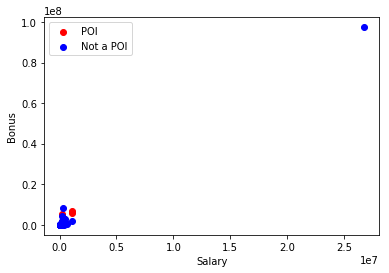

In [60]:
pois = enrondf[enrondf.poi]
plt.scatter(pois["salary"], pois["bonus"], c='red');
nonpois = enrondf[~enrondf.poi]
plt.scatter(nonpois["salary"], nonpois["bonus"], c='blue');
plt.xlabel("Salary")
plt.ylabel("Bonus")

plt.legend(["POI","Not a POI"])

Plotting the salary and bonuses of all the executives on a simple scatter plot immediately brings one outlier to our attention and looking at the executives with salary above $2M, it is very clear that the record which says Total is actually just the total of all the executives salary put together. 

Since, this is unnecessary for our model and might even skew the algorithm, I'm dropping this record as well.

In [61]:
#Identifying outliers by looking at the top earners
enrondf[enrondf.loc[:,"salary"]>2000000]

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
TOTAL,26704229.0,2007.111111,32083396.0,309886585.0,311764000.0,97343619.0,130322299.0,1058.527778,-7576788.0,434509511.0,...,83925000.0,668.763889,42667589.0,36.277778,False,1398517.0,-27992891.0,48521928.0,0,58.5


In [62]:
#Drop Total as it looks like the total of everybody's salaries
enrondf = enrondf.drop("TOTAL")

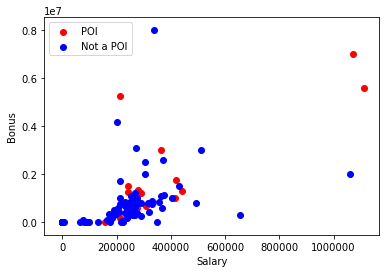

In [63]:
pois = enrondf[enrondf.poi]
plt.scatter(pois["salary"], pois["bonus"], c='red');
nonpois = enrondf[~enrondf.poi]
plt.scatter(nonpois["salary"], nonpois["bonus"], c='blue');
plt.xlabel("Salary")
plt.ylabel("Bonus")

plt.legend(["POI","Not a POI"])

#Mark Frevert although not a POI seems to have made a lot of money from Enron
#Difficult to use K_means as clustering might not give the best result here

In [64]:
# Remove the outlier individuals , 'BAXTER JOHN C'
#enrondf.drop(axis=0, labels=['FREVERT MARK A', 'LAVORATO JOHN J', 'WHALLEY LAWRENCE G'], inplace=True)

In [65]:
#Final numbers before moving onto modeling algorithms
print 'Number of executives:', len(enrondf)
print 'Number of Features:', len(enrondf.keys())

print 'Number of POIs:', len(enrondf.loc[enrondf.loc[:,"poi"]==True])

Number of executives: 143
Number of Features: 21
Number of POIs: 18


In [66]:
enrondf[enrondf==0].count().sum()

1186

In [67]:
from sklearn.preprocessing import scale
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier

def set_classifier(x):
    # switch statement Python replacement - http://stackoverflow.com/a/103081
    return {
        'rfc': RandomForestClassifier(),
        'dtr': DecisionTreeClassifier(),
        'gnb': GaussianNB(),
        'kn': KNeighborsClassifier(2),
        'ada': AdaBoostClassifier(),
        'xtra': ExtraTreesClassifier(),
        'km': KMeans(n_clusters=2, random_state=0)
    }.get(x)

In [68]:
import tester

my_dataset = enrondf[features_list].to_dict(orient='index')

#Test for all the algorithms defined earlier
for classifier in ['rfc','dtr','gnb','kn','ada','xtra','km']:
    clf = set_classifier(classifier)
    tester.dump_classifier_and_data(clf, my_dataset, features_list)
    tester.main();

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
	Accuracy: 0.86853	Precision: 0.52059	Recall: 0.17700	F1: 0.26418	F2: 0.20392
	Total predictions: 15000	True positives:  354	False positives:  326	False negatives: 1646	True negatives: 12674

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
	Accuracy: 0.82093	Precision: 0.33170

##### the results are summarized below:

| Classifier            | Precision | Recall  | F1 Score | Accuracy |
|-----------------------|-----------|---------|----------|----------|
| RandomForest          | 0.55      | 0.17    | 0.27     | 0.87     |
| GaussianNB            | 0.23      | 0.37    | 0.30     | 0.76     |
| DecisionTree          | 0.33      | 0.34    | 0.33     | 0.82     |
| KNeighbors            | 0.35      | 0.05    | 0.09     | 0.86     |
| AdaBoost              | 0.48      | 0.35    | 0.40     | 0.86     |
| ExtraTrees            | 0.50      | 0.17    | 0.26     | 0.86     |
| KMeans (n_clusters=2) | 0.21      | 0.08    | 0.12     | 0.83     |

I already have some good numbers with an initial run on a set of 8 algorithms and the best performing so far considering both accuracy and F1 score seems to be AdaBoost and DecisionTree.

### Feature Engineering

Now, I want to add a few features to the feature list to try and see how these new features would affect the accuracy and scores of all the above algorithms. 

I add 3 new features 
                     * fraction_from_poi - ratio of emails from poi to this person
                     * fraction_to_poi - ratio of emails from this person to poi
                     * fraction_shared_receipt - share receipt with poi and this person
                     

In [69]:
### Task 3: Create new feature(s)
enrondf['fraction_from_poi'] = enrondf['from_poi_to_this_person'] / enrondf['to_messages']
enrondf['fraction_to_poi'] = enrondf['from_this_person_to_poi'] / enrondf['from_messages']
enrondf['fraction_shared_receipt'] = enrondf['shared_receipt_with_poi'] / enrondf['to_messages']

features_list.append('fraction_from_poi')
features_list.append('fraction_to_poi')
features_list.append('fraction_shared_receipt')

# Replacing 'NaN' in financial features with 0
enrondf = enrondf.fillna(0)


# back into dict
data_dict = enrondf.to_dict(orient='index')

for classifier in ['rfc','dtr','gnb','kn','ada','xtra','km']:
    clf = set_classifier(classifier)
    tester.dump_classifier_and_data(clf, data_dict, features_list)
    tester.main();

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
	Accuracy: 0.88587	Precision: 0.68367	Recall: 0.26800	F1: 0.38506	F2: 0.30510
	Total predictions: 15000	True positives:  536	False positives:  248	False negatives: 1464	True negatives: 12752

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
	Accuracy: 0.89820	Precision: 0.62184

the results for all of the algorithms have improved and are summarized below:

| Classifier            | Precision | Recall  | F1 Score | Accuracy |
|-----------------------|-----------|---------|----------|----------|
| RandomForest          | 0.67      | 0.27    | 0.36     | 0.88     |
| GaussianNB            | 0.25      | 0.37    | 0.30     | 0.76     |
| DecisionTree          | 0.61      | 0.61    | 0.61     | 0.89     |
| KNeighbors            | 0.35      | 0.05    | 0.09     | 0.86     |
| AdaBoost              | 0.65      | 0.53    | 0.58     | 0.89     |
| ExtraTrees            | 0.64      | 0.27    | 0.38     | 0.88     |
| KMeans (n_clusters=2) | 0.21      | 0.08    | 0.12     | 0.83     |

Adding these features to the list has improved the precision and recall scores of some of the algorithms.

I add 2 more features - 
                     * bonus_to_salary - ratio of bonus to salary
                     * bonus_to_total - ratio of bonus to total payments

I then run the algorithms defined earlier again with default parameters to see if adding these parameters has made any difference in the accuracy or/and score of the algorithms.

In [70]:
# Create the new financial features and add to the dataframe
enrondf['bonus_to_salary'] = enrondf['bonus'] / enrondf['salary']
enrondf['bonus_to_total'] = enrondf['bonus'] / enrondf['total_payments']    

features_list.append('bonus_to_salary')
features_list.append('bonus_to_total')   

In [71]:
# Replacing 'NaN' in financial features with 0
enrondf = enrondf.fillna(0)

### Store to my_dataset for easy export below.
# featureFormat expects 'NaN' strings

# back into dict
data_dict = enrondf.to_dict(orient='index')

for classifier in ['rfc','dtr','gnb','kn','ada','xtra','km']:
    clf = set_classifier(classifier)
    tester.dump_classifier_and_data(clf, data_dict, features_list)
    tester.main();

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
	Accuracy: 0.88133	Precision: 0.63580	Recall: 0.25750	F1: 0.36655	F2: 0.29228
	Total predictions: 15000	True positives:  515	False positives:  295	False negatives: 1485	True negatives: 12705

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
	Accuracy: 0.89953	Precision: 0.62661

Adding these two features did not improve the accuracy or the f1 score but conversely decreased the f1 scores and accuracy of a few algorithms and so I removed last two features from the list. 

| Classifier            | Precision | Recall  | F1 Score | Accuracy |
|-----------------------|-----------|---------|----------|----------|
| RandomForest          | 0.62      | 0.23    | 0.34     | 0.87     |
| GaussianNB            | 0.25      | 0.37    | 0.30     | 0.76     |
| DecisionTree          | 0.62      | 0.60    | 0.61     | 0.89     |
| KNeighbors            | 0.35      | 0.05    | 0.09     | 0.86     |
| AdaBoost              | 0.62      | 0.51    | 0.51     | 0.89     |
| ExtraTrees            | 0.63      | 0.25    | 0.36     | 0.88     |
| KMeans (n_clusters=2) | 0.21      | 0.08    | 0.12     | 0.83     |

The worst performing algorithms with precision and recall have been KNeighbors and KMeans and the best, DecisionTree and AdaBoost. 

In [72]:
#Accuracy and F1 scores are lower with these features

features_list.remove('bonus_to_total') 
features_list.remove('bonus_to_salary')

### Feature Selection

The F1 score and accuracy scores already meet our criteria but, so far it has only been based on the features that I manually selected and each algorithm's default parameter settings.

Now, I would like to use SelectKBest to let scikit learn pick the best features.

In [73]:
from feature_format import featureFormat, targetFeatureSplit
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV

data_dict = enrondf.to_dict(orient='index')
data = featureFormat(data_dict, features_list)
labels, features = targetFeatureSplit(data)

In [82]:
#DecisionTree KBest
n_features = np.arange(1, len(features_list))

pipe = Pipeline([
    ('select_features', SelectKBest()),
    ('classify', set_classifier('dtr'))
])

param_grid = [
    {
        'select_features__k': n_features
    }
]

# Use GridSearchCV to automate the process of finding the optimal number of features
tree_clf= GridSearchCV(pipe, param_grid=param_grid, scoring='f1', cv = 10)
tree_clf.fit(features, labels);


In [83]:
tree_clf.best_params_

{'select_features__k': 17}

In [84]:
tree_selection = SelectKBest(k=17)
tree_selection.fit_transform(features, labels)

tree_scores = tree_selection.scores_
tree_features = zip(tree_scores, features_list[1:])
tree_features = sorted(tree_features, key= lambda x:x[0], reverse=True)

print('Tree Feature F-statistics:\n')
for i in range(17):
    print('{} : {:.4f}'.format(tree_features[i][1], tree_features[i][0]))

Tree Feature F-statistics:

fraction_to_poi : 25.8782
total_stock_value : 22.5105
exercised_stock_options : 22.3490
bonus : 20.7923
salary : 18.2897
fraction_shared_receipt : 15.6936
deferred_income : 11.4249
shared_receipt_with_poi : 10.4091
long_term_incentive : 9.9222
total_payments : 9.2839
restricted_stock : 8.8254
loan_advances : 7.1841
from_poi_to_this_person : 5.4787
expenses : 5.4189
other : 4.2024
fraction_from_poi : 2.5928
from_this_person_to_poi : 2.4456


In [85]:
tree_clf = Pipeline([
    ('select_features', SelectKBest(k=17)),
    ('classify', set_classifier('dtr')),
])

tester.dump_classifier_and_data(tree_clf, data_dict, features_list)
tester.main()

Pipeline(memory=None,
     steps=[('select_features', SelectKBest(k=17, score_func=<function f_classif at 0x000000000BE69358>)), ('classify', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])
	Accuracy: 0.90313	Precision: 0.64149	Recall: 0.62000	F1: 0.63056	F2: 0.62418
	Total predictions: 15000	True positives: 1240	False positives:  693	False negatives:  760	True negatives: 12307



In [86]:
#AdaBoost KBest
pipe = Pipeline([
    ('select_features', SelectKBest()),
    ('classify', set_classifier('ada'))
])

param_grid = [
    {
        'select_features__k': n_features
    }
]

tree_clf = set_classifier('ada')

tree_clf= GridSearchCV(pipe, param_grid=param_grid, scoring='f1', cv = 10)
tree_clf.fit(features, labels)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('select_features', SelectKBest(k=10, score_func=<function f_classif at 0x000000000BE69358>)), ('classify', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'select_features__k': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [87]:
tree_clf.best_params_

{'select_features__k': 15}

In [88]:
tree_selection = SelectKBest(k=15)
tree_selection.fit_transform(features, labels)

tree_scores = tree_selection.scores_
tree_features = zip(tree_scores, features_list[1:])
tree_features = sorted(tree_features, key= lambda x:x[0], reverse=True)


print('Tree Feature F-statistics:\n')
for i in range(15):
    print('{} : {:.3f}'.format(tree_features[i][1], tree_features[i][0]))

Tree Feature F-statistics:

fraction_to_poi : 25.878
total_stock_value : 22.511
exercised_stock_options : 22.349
bonus : 20.792
salary : 18.290
fraction_shared_receipt : 15.694
deferred_income : 11.425
shared_receipt_with_poi : 10.409
long_term_incentive : 9.922
total_payments : 9.284
restricted_stock : 8.825
loan_advances : 7.184
from_poi_to_this_person : 5.479
expenses : 5.419
other : 4.202


In [89]:
tree_clf = Pipeline([
    ('select_features', SelectKBest(k=15)),
    ('classify', set_classifier('ada')),
])

tester.dump_classifier_and_data(tree_clf, data_dict, features_list)
tester.main()

Pipeline(memory=None,
     steps=[('select_features', SelectKBest(k=15, score_func=<function f_classif at 0x000000000BE69358>)), ('classify', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))])
	Accuracy: 0.89940	Precision: 0.64085	Recall: 0.55850	F1: 0.59685	F2: 0.57323
	Total predictions: 15000	True positives: 1117	False positives:  626	False negatives:  883	True negatives: 12374



### Parameter Tuning

I use GridSearchCV to pick the best parameter value setting based on the algorithms and the features selected. 

In [91]:
# Decision Tree Classifier
tree_pipe = Pipeline([
    ('select_features', SelectKBest(k=17)),
    ('classify', DecisionTreeClassifier()),
])

param_grid = dict(classify__criterion = ['gini', 'entropy'] , 
                  classify__min_samples_split = [2, 4, 6, 8, 10, 20],
                  classify__max_depth = [None, 5, 10, 15, 20],
                  classify__max_features = [None, 'sqrt', 'log2', 'auto'])

# Use GridSearchCV to find the optimal hyperparameters for the classifier
tree_clf = GridSearchCV(tree_pipe, param_grid = param_grid, scoring='f1', cv=10)
tree_clf.fit(features, labels)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('select_features', SelectKBest(k=17, score_func=<function f_classif at 0x000000000BE69358>)), ('classify', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impu...     min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'classify__max_features': [None, 'sqrt', 'log2', 'auto'], 'classify__min_samples_split': [2, 4, 6, 8, 10, 20], 'classify__criterion': ['gini', 'entropy'], 'classify__max_depth': [None, 5, 10, 15, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [92]:
tree_clf.best_score_

0.76107226107226111

In [93]:
tree_clf.best_params_

{'classify__criterion': 'entropy',
 'classify__max_depth': None,
 'classify__max_features': None,
 'classify__min_samples_split': 20}

In [94]:
# Create the classifier with the optimal hyperparameters as found by GridSearchCV

tree_clf = Pipeline([
    ('select_features', SelectKBest(k=17)),
    ('classify', DecisionTreeClassifier(criterion='entropy',max_depth=None, max_features=None, min_samples_split=20))
     ])
    
# Test the classifier using tester.py
tester.dump_classifier_and_data(tree_clf, data_dict, features_list)
tester.main()

Pipeline(memory=None,
     steps=[('select_features', SelectKBest(k=17, score_func=<function f_classif at 0x000000000BE69358>)), ('classify', DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])
	Accuracy: 0.92367	Precision: 0.68660	Recall: 0.78650	F1: 0.73316	F2: 0.76426
	Total predictions: 15000	True positives: 1573	False positives:  718	False negatives:  427	True negatives: 12282



In [95]:
# AdaBoost
pipe = Pipeline([
    ('select_features', SelectKBest(k=15)),
    ('classify', set_classifier('ada'))
])

param_grid = dict(classify__base_estimator=[DecisionTreeClassifier(), RandomForestClassifier()],
                  classify__n_estimators = [50, 100, 500, 750, 1000, 2000, 5000],
                  classify__learning_rate = [0.5, 1, 1.25, 1.5, 2])

# Use GridSearchCV to automate the process of finding the optimal number of features
ada_clf= GridSearchCV(pipe, param_grid=param_grid, scoring='f1', cv = 10)
ada_clf.fit(features, labels)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('select_features', SelectKBest(k=15, score_func=<function f_classif at 0x000000000BE69358>)), ('classify', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'classify__learning_rate': [0.5, 1, 1.25, 1.5, 2], 'classify__n_estimators': [50, 100, 500, 750, 1000, 2000, 5000], 'classify__base_estimator': [DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [96]:
ada_clf.best_score_

0.69580419580419584

In [97]:
ada_clf.best_params_

{'classify__base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=None,
             splitter='best'),
 'classify__learning_rate': 0.5,
 'classify__n_estimators': 1000}

In [100]:
# Create the classifier with the optimal hyperparameters as found by GridSearchCV

ada_clf = Pipeline([
    ('select_features', SelectKBest(k=15)),
    ('classify', AdaBoostClassifier(base_estimator = DecisionTreeClassifier(criterion='gini',max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2)
                ,learning_rate=0.5, n_estimators=1000))
     ])
    
# Test the classifier using tester.py
tester.dump_classifier_and_data(ada_clf, data_dict, features_list)
tester.main()

Pipeline(memory=None,
     steps=[('select_features', SelectKBest(k=15, score_func=<function f_classif at 0x000000000BE69358>)), ('classify', AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_node...,
            splitter='best'),
          learning_rate=0.5, n_estimators=1000, random_state=None))])
	Accuracy: 0.90300	Precision: 0.64112	Recall: 0.61900	F1: 0.62987	F2: 0.62330
	Total predictions: 15000	True positives: 1238	False positives:  693	False negatives:  762	True negatives: 12307



### Conclusions

Below are the final results from the two algorithms I've chosen.

| Classifier            | Precision | Recall  | F1 Score | Accuracy |
|-----------------------|-----------|---------|----------|----------|
| Decision Tree         | 0.68      | 0.78    | 0.73     | 0.92     |
| Ada Boost             | 0.64      | 0.61    | 0.63     | 0.90     |

Based on these numbers, I pick Decision Tree classifier as my final model.

The accuracy of 0.92 means that my model is accurate 92 times on 100 and a precision of 0.68 means that 68% of times POI were indeed POI as predicted by my model and a recall score of 0.78 means that it identified 78% of POI in the dataset.

The most important aspect of improving my model was selecting the best possible features as the right features improved the overall accuracy and f1 scores of algorithms and vice versa. Further, tuning the algorithms for the best possible parameters helped a great deal in getting the best results. I also want to point out that the amount of tidy data matters as the algorithms would have a bigger data set to train against and eventually perform better on test sets.

**References**

* [Enron Scandal](https://en.wikipedia.org/wiki/Enron_scandal)
* [Scikit Learn Documentation](http://scikit-learn.org/stable/documentation.html)
* [Scikit Learn Cheatsheet](https://www.datacamp.com/community/blog/scikit-learn-cheat-sheet)